# **Proyecto 02: Clasificación Supervisada**

---

### **Integrantes**:
- Kalos Lazo
- Benjamín Soto
- Lucas Carranza
- José Osnayo

---

### **Importar librerías escenciales**

A continuación se importarán las librerías escenciales para proceder con nuestro análisis exploratorio de datos (EDA), los archivos utilizan el formato `.h5` destinado para trabajar con archivos complejos, se procederá a utilizar la librería `h5py`.

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import h5py

from tsfresh import extract_features
from tsfresh.feature_extraction import MinimalFCParameters
from tsfresh.utilities.dataframe_functions import make_forecasting_frame

from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

---

### **Data**

Considerando que dentro de nuestra estructura contamos con una carpeta de datos en la localización raíz `/data`, importamos los archivos train y test para entrenamiento y testeo respectivamente.

Se procede a crear una [función](https://stackoverflow.com/questions/28170623/how-to-read-hdf5-files-in-python) para convertir de nuestros archivos de `.h5` a un pandas dataframe, de tal forma que podamos utilizar nuestros datos al aplicar el modelo. La función toma la ubicación del archivo y convierte cada dataset en un elemento del tipo numpy array, posteriormente se instancia como un objeto pandas dataframe.

Por último una vez tenemos un diccionario de dataframes, se hace esto para mantener el nombre de cada dataset para un posterior análisis y correctitud. Esto se logra al ver que al sacar las features y juntar todas las características necesitamos un mecanismo que diferencie entre las columnas.

In [5]:
def file_data_processing(path):
    with h5py.File(path, 'r') as hf:
        return {each_dataset: pd.DataFrame(hf[each_dataset][()]) for each_dataset in hf}

path = './data/'
train_path = f'{path}/train.h5'
test_path = f'{path}/test.h5'

train_data = file_data_processing(train_path)
test_data = file_data_processing(test_path)

print("Claves de columnas en train_data\n:", train_data.keys())
print("\nClaves de columnas en test_data\n:", test_data.keys())

Claves de columnas en train_data
: dict_keys(['body_acc_x', 'body_acc_y', 'body_acc_z', 'body_gyro_x', 'body_gyro_y', 'body_gyro_z', 'total_acc_x', 'total_acc_y', 'total_acc_z', 'y'])

Claves de columnas en test_data
: dict_keys(['body_acc_x', 'body_acc_y', 'body_acc_z', 'body_gyro_x', 'body_gyro_y', 'body_gyro_z', 'total_acc_x', 'total_acc_y', 'total_acc_z'])


---

### **Extracción de características**

Hasta ahora contamos con una matriz de matrices, donde en cada uno de sus hijos interiores representa un dataset del usuario para una respectiva acción con sus EEG, por ejemplo el de caminar hacia arriba, caminar hacia abajo, entre otras.

Al tener 128 características por lo que debemos inicialmente reducir la dimensionalidad, utilizaremos la reducción por LDA (Linear Discriminant Analysis), una vez logramos esto individualmente, procedemos a juntarlos todos en una matriz. Si no hicieramos esta reducción trabajaríamos con una matriz de $128 \cdot 9 = 1152$ características. 

In [6]:
def dataset_descriptive_features(df, dataset_name):
    df_conversion_long = df.copy();
    df_conversion_long['id'] = df.index;
    df_conversion_long = df_conversion_long.melt(id_vars=['id'], var_name='time', value_name='value')
    
    extracted_features = extract_features(df_conversion_long, column_id = 'id', column_sort = 'time',  default_fc_parameters = MinimalFCParameters(), n_jobs=4)
    extracted_features.columns = [f"{dataset_name}_{each_col}" for each_col in extracted_features.columns]
    
    return extracted_features

def get_datasets_features(train_data):
    features_list = [];
    for name, df in train_data.items():
        if name != 'y':
            extracted_features = dataset_descriptive_features(df, name)
            print(f"Dimension de características extraídas en {name}: {extracted_features.shape}")
            features_list.append(extracted_features)
    return features_list;

x_train_features = get_datasets_features(train_data);
x_test_features = get_datasets_features(test_data);

Feature Extraction: 100%|████████████████████████████████████████████████| 20/20 [00:01<00:00, 14.78it/s]

Dimension de características extraídas en body_acc_x: (7352, 10)



Feature Extraction: 100%|████████████████████████████████████████████████| 20/20 [00:01<00:00, 16.07it/s]


Dimension de características extraídas en body_acc_y: (7352, 10)


Feature Extraction: 100%|████████████████████████████████████████████████| 20/20 [00:01<00:00, 14.27it/s]


Dimension de características extraídas en body_acc_z: (7352, 10)


Feature Extraction: 100%|████████████████████████████████████████████████| 20/20 [00:01<00:00, 15.05it/s]

Dimension de características extraídas en body_gyro_x: (7352, 10)



Feature Extraction: 100%|████████████████████████████████████████████████| 20/20 [00:01<00:00, 16.24it/s]


Dimension de características extraídas en body_gyro_y: (7352, 10)


Feature Extraction: 100%|████████████████████████████████████████████████| 20/20 [00:01<00:00, 14.80it/s]


Dimension de características extraídas en body_gyro_z: (7352, 10)


Feature Extraction: 100%|████████████████████████████████████████████████| 20/20 [00:01<00:00, 16.01it/s]


Dimension de características extraídas en total_acc_x: (7352, 10)


Feature Extraction: 100%|████████████████████████████████████████████████| 20/20 [00:01<00:00, 14.35it/s]


Dimension de características extraídas en total_acc_y: (7352, 10)


Feature Extraction: 100%|████████████████████████████████████████████████| 20/20 [00:01<00:00, 16.10it/s]


Dimension de características extraídas en total_acc_z: (7352, 10)


Feature Extraction: 100%|████████████████████████████████████████████████| 20/20 [00:00<00:00, 33.53it/s]

Dimension de características extraídas en body_acc_x: (2947, 10)



Feature Extraction: 100%|████████████████████████████████████████████████| 20/20 [00:00<00:00, 36.82it/s]


Dimension de características extraídas en body_acc_y: (2947, 10)


Feature Extraction: 100%|████████████████████████████████████████████████| 20/20 [00:00<00:00, 35.63it/s]


Dimension de características extraídas en body_acc_z: (2947, 10)


Feature Extraction: 100%|████████████████████████████████████████████████| 20/20 [00:00<00:00, 36.18it/s]

Dimension de características extraídas en body_gyro_x: (2947, 10)



Feature Extraction: 100%|████████████████████████████████████████████████| 20/20 [00:00<00:00, 38.11it/s]

Dimension de características extraídas en body_gyro_y: (2947, 10)



Feature Extraction: 100%|████████████████████████████████████████████████| 20/20 [00:00<00:00, 37.67it/s]

Dimension de características extraídas en body_gyro_z: (2947, 10)



Feature Extraction: 100%|████████████████████████████████████████████████| 20/20 [00:00<00:00, 41.29it/s]

Dimension de características extraídas en total_acc_x: (2947, 10)



Feature Extraction: 100%|████████████████████████████████████████████████| 20/20 [00:00<00:00, 33.40it/s]

Dimension de características extraídas en total_acc_y: (2947, 10)



Feature Extraction: 100%|████████████████████████████████████████████████| 20/20 [00:00<00:00, 38.37it/s]

Dimension de características extraídas en total_acc_z: (2947, 10)


Con la función anterior, `descriptive_features`, se logra obtener las características más importantes y descriptivas de cada dataset. Podríamos hacerlo manual obteniendo mediana, mínimo, máximo, entre otros, pero para este caso ya utilizamos funcionalidad hecha por la librería de [TsFresh](https://tsfresh.readthedocs.io/en/latest/): extrae automáticamente [características importantes](https://www.linkedin.com/pulse/unlocking-time-series-insights-tsfresh-python-guide-rany-5yr7c/) acerca de una serie temporal.

Para aplicar este método primero debe convertirse el dataframe a un formato largo (long) que es exigido por la librería, se basa en una matriz tal que cada fila es una observación y cada columna un momento del tiempo, posteriormente ese train data sera dividido para el eje X, Y. El resultado esperado en `x_train_features` es almacenar una lista con las features más importantes obtenidas de cada dataset.

In [7]:
X_train = pd.concat(x_train_features, axis = 1).dropna(axis = 1).reset_index(drop = True)
Y_train = pd.DataFrame(train_data['y'].to_numpy().flatten())

X_test = pd.concat(x_test_features, axis=1).dropna(axis=1).reset_index(drop=True)

print(f"Dimensiones de X_train: {X_train.shape}")
print(f"Dimensiones de Y_train: {Y_train.shape}")
print(f"Dimensiones de X_test: {X_test.shape}")

Dimensiones de X_train: (7352, 90)
Dimensiones de Y_train: (7352, 1)
Dimensiones de X_test: (2947, 90)


Una vez realizado este proceso contaremos con nuevas columnas en nuestro `X_train`, pues hemos aplicado una funcionalidad de la librería TsFresh y hemos escarbado la información más importante de nuestra serie de tiempo (*time series*). Cabe resaltar que `X_train` está concatenando múltiples Dataframes en uno solo: `x_train_features`, la opción `axis = 1` indica que será por medio de las columnas, se eliminan las columnas con valores `NaN` y se elimina el indice anterior. En el caso de Y sólo se convierte en vector unidimensional con `flatten`.

In [8]:
X_train.keys()

Index(['body_acc_x_value__sum_values', 'body_acc_x_value__median',
       'body_acc_x_value__mean', 'body_acc_x_value__length',
       'body_acc_x_value__standard_deviation', 'body_acc_x_value__variance',
       'body_acc_x_value__root_mean_square', 'body_acc_x_value__maximum',
       'body_acc_x_value__absolute_maximum', 'body_acc_x_value__minimum',
       'body_acc_y_value__sum_values', 'body_acc_y_value__median',
       'body_acc_y_value__mean', 'body_acc_y_value__length',
       'body_acc_y_value__standard_deviation', 'body_acc_y_value__variance',
       'body_acc_y_value__root_mean_square', 'body_acc_y_value__maximum',
       'body_acc_y_value__absolute_maximum', 'body_acc_y_value__minimum',
       'body_acc_z_value__sum_values', 'body_acc_z_value__median',
       'body_acc_z_value__mean', 'body_acc_z_value__length',
       'body_acc_z_value__standard_deviation', 'body_acc_z_value__variance',
       'body_acc_z_value__root_mean_square', 'body_acc_z_value__maximum',
       'body_ac

En este caso podemos ver cómo reducimos la complejidad ahora con $90$ columnas de las cuales tenemos la información escencial de las líneas de tiempo, que anteriormente eran $128 \cdot 9$. Con esta información nuestro modelo ya puede empezar a ser entrenado. Se verifica posteriormente que se preservan las filas iniciales, en este caso $7352$.

In [9]:
X_train.head()

,body_acc_x_value__sum_values,body_acc_x_value__median,body_acc_x_value__mean,body_acc_x_value__length,body_acc_x_value__standard_deviation,body_acc_x_value__variance,body_acc_x_value__root_mean_square,body_acc_x_value__maximum,body_acc_x_value__absolute_maximum,body_acc_x_value__minimum,...,total_acc_z_value__sum_values,total_acc_z_value__median,total_acc_z_value__mean,total_acc_z_value__length,total_acc_z_value__standard_deviation,total_acc_z_value__variance,total_acc_z_value__root_mean_square,total_acc_z_value__maximum,total_acc_z_value__absolute_maximum,total_acc_z_value__minimum
0,0.290392,0.002025,0.002269,128.0,0.002941,0.000009,0.003714,0.010810,0.010810,-0.004294,...,12.765670,0.099841,0.099732,128.0,0.003970,0.000016,0.099811,0.109485,0.109485,0.088742
1,0.022239,0.000110,0.000174,128.0,0.001981,0.000004,0.001989,0.005251,0.006706,-0.006706,...,12.408253,0.097748,0.096939,128.0,0.004918,0.000024,0.097064,0.105788,0.105788,0.081100
2,0.054796,0.000627,0.000428,128.0,0.002908,0.000008,0.002940,0.008167,0.010483,-0.010483,...,11.890790,0.093636,0.092897,128.0,0.006145,0.000038,0.093100,0.105788,0.105788,0.081100
3,0.042157,0.000269,0.000329,128.0,0.002678,0.000007,0.002698,0.008167,0.010483,-0.010483,...,11.219701,0.087501,0.087654,128.0,0.004945,0.000024,0.087793,0.098737,0.098737,0.076888
4,-0.024980,-0.000144,-0.000195,128.0,0.002015,0.000004,0.002025,0.005650,0.006847,-0.006847,...,10.879856,0.084765,0.084999,128.0,0.003637,0.000013,0.085077,0.093388,0.093388,0.074595


---
### **Exploración de Datos**

Lo primero que queremos es conocer nuestras features que previamente han sido modificados, es así que como primer paso podemos usar la función `describe()` que permite de manera sencilla obtener estadísticas descriptivas de nuestras columnas.

In [10]:
X_train.describe().T

,count,mean,std,min,25%,50%,75%,max
body_acc_x_value__sum_values,7352.0,-0.081447,1.853377,-33.700321,-0.385138,-0.010087,0.287138,19.056348
body_acc_x_value__median,7352.0,-0.024342,0.044907,-0.285125,-0.038399,-0.001441,0.000300,0.151517
body_acc_x_value__mean,7352.0,-0.000636,0.014480,-0.263284,-0.003009,-0.000079,0.002243,0.148878
body_acc_x_value__length,7352.0,128.000000,0.000000,128.000000,128.000000,128.000000,128.000000,128.000000
body_acc_x_value__standard_deviation,7352.0,0.129105,0.145224,0.001413,0.003758,0.018826,0.246462,0.648675
...,...,...,...,...,...,...,...,...
total_acc_z_value__variance,7352.0,0.010558,0.015461,0.000009,0.000033,0.000413,0.017381,0.127318
total_acc_z_value__root_mean_square,7352.0,0.285424,0.232424,0.003700,0.125216,0.202054,0.374049,0.988379
total_acc_z_value__maximum,7352.0,0.245178,0.306718,-0.978027,0.042551,0.213361,0.420355,1.281363
total_acc_z_value__absolute_maximum,7352.0,0.448607,0.289168,0.007652,0.226644,0.402390,0.644768,1.639609


Antes de mostrar gráficamente estos datos, vamos a utilizar la información de `Y` que está numérica desde el `1 \to 6` que indica la acción, por ejemplo "WALKING", por ello vamos a utilizar estos labels considerando el orden lógico propuesto en el enunciado.

In [11]:
Y_train[0].unique()

array([5., 4., 6., 1., 3., 2.])

Hemos creado una función para asignar cada elemento de `Y_train` a el obtenido dentro de sus filas, de esta forma contamos las apariciones y es posible gráficamente comparar y notar que `LAYING: 5`, es el que más apareció dentro de los registros de entrenamiento. Otra cosa a mencionar es que las actividades con su etiqueta asociada están distribuidas de manera equitativa.

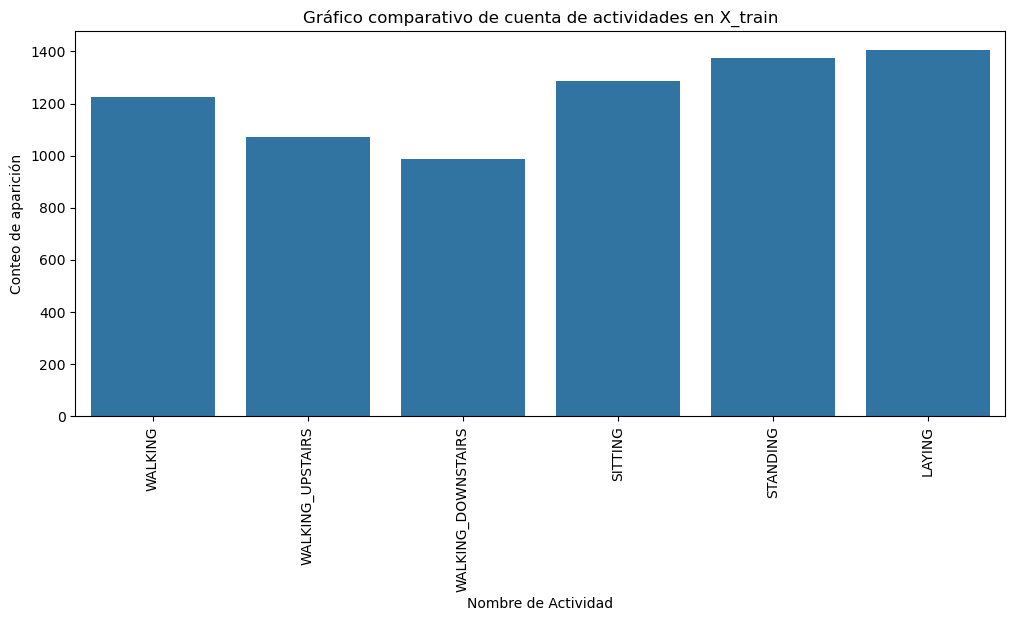

In [12]:
def assign_key_labels(df, arr_to_mapped):
    activities_map = {i+1: arr_to_mapped[i] for i in range(len(arr_to_mapped))}
    activities_mapped = df[0].map(activities_map);
    df_mapped = pd.DataFrame({'Activity': activities_mapped});
    
    return df_mapped;
    
labels_actions = ['WALKING', 'WALKING_UPSTAIRS', 'WALKING_DOWNSTAIRS', 'SITTING', 'STANDING', 'LAYING']
Y_train_label = assign_key_labels(Y_train, labels_actions)


plt.figure(figsize=(12,5))
sns.countplot(x='Activity', data=Y_train_label, order=labels_actions)
plt.xticks(rotation='vertical')
plt.title('Gráfico comparativo de cuenta de actividades en X_train')
plt.xlabel('Nombre de Actividad')
plt.ylabel('Conteo de aparición')
plt.show()

---

### **Procesamiento de datos**

Ahora, se procede con la división de los conjuntos de datos, usando la función `train_test_split()` de la librería `sklearn.model_selection`, obtenemos los valores de entrenamiento y validación.

No obstante se proceden a escalar los datos, tanto de entranemiento como de validación, esto es necesario para el modelo seleccionado de K-NN, se logra usando `StandardScaler()` de la librería `sklearn.preprocessing`.

In [13]:
X_train_split, X_val, Y_train_split, Y_val = train_test_split(X_train, Y_train, test_size = 0.2, random_state = 42)
scaler = StandardScaler()

X_train_split = scaler.fit_transform(X_train_split)
X_val = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

## Modelos de Clasificación

### **Modelo 1: Reemplazar por K-NN PROPIO**

In [14]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=5)

# ENTRENANDO MODELO
knn.fit(X_train_split, Y_train_split.values.ravel())

# PREDICCION DE Y
Y_val_pred = knn.predict(X_val)

# MOSTRAR % DE PREDICCION

# - PRECISIÓN
accuracy_val = accuracy_score(Y_val, Y_val_pred)
print(f"Precisión en el conjunto de validación: {accuracy_val * 100:.2f}%")

# - CLASIFICACION
print(classification_report(Y_val, Y_val_pred, target_names=labels_actions))

Precisión en el conjunto de validación: 95.24%
                    precision    recall  f1-score   support

           WALKING       0.91      0.98      0.95       247
  WALKING_UPSTAIRS       0.96      0.92      0.94       200
WALKING_DOWNSTAIRS       0.98      0.93      0.95       206
           SITTING       0.93      0.94      0.93       262
          STANDING       0.94      0.93      0.94       276
            LAYING       1.00      1.00      1.00       280

          accuracy                           0.95      1471
         macro avg       0.95      0.95      0.95      1471
      weighted avg       0.95      0.95      0.95      1471



### **Modelo 2: Decision Tree**

In [33]:
MAX_DEPTH = 10
MIN_SAMPLE = 3
NINF = -float("inf")

def entropy(y):
    n = len(y)
    _, counts = np.unique(y, return_counts=True)
    p = counts / n
    h = -np.sum(p * np.log2(p))
    return h

def gini(y):
    n = len(y)
    _, counts = np.unique(y, return_counts=True)
    p = counts / n
    gini = 1 - np.sum(p**2)
    return gini

def get_info(parent_y, left_y, right_y, method="e"):
    peso_l = len(left_y) / len(parent_y)
    peso_r = len(right_y) / len(parent_y)
    
    if method == "e":
        return entropy(parent_y) - (peso_l*entropy(left_y) + peso_r*entropy(right_y)) 
    else:
        return gini(parent_y) - (peso_l*gini(left_y) + peso_r*gini(right_y))

# Nodo Decision o Nodo Hoja
class Nodo:
    def __init__(self, index=None, left=None, right=None, info=None, umbral=None):
        self.index = index
        self.left = left
        self.right = right
        self.info = info
        self.umbral = umbral

        self.leaf = False
        self.valor = None
    
    def make_leaf(self, y):
        y = list(y)
        self.valor = max(y, key=y.count)
        self.leaf = True
    
# Clase para almacenar la informacion de un split
class Split:
    def __init__(self, index=None, left=None, right=None, info=NINF, umbral=None):
        self.index = index
        self.left = left
        self.right = right
        self.info = info
        self.umbral = umbral
    
    def update(self, new_index, new_left, new_right, new_info, new_umbral):
        if new_info > self.info:
            self.index = new_index
            self.left = new_left
            self.right = new_right
            self.info = new_info
            self.umbral = new_umbral

    def to_node(self, left, right):
        return Nodo(index=self.index, left=left, right=right, info=self.info, umbral=self.umbral)
    
# Arbol de Decision
class DT:
    def __init__(self, X, Y, max_depth=MAX_DEPTH, min_sample=MIN_SAMPLE, method="g"):
        self._max_depth = max_depth
        self._min_sample = min_sample
        self._method = method
        self.root = self.build(np.concatenate((X, Y), axis=1))
    
    def build(self, data, depth=0):
        # print(f"node at depth: {depth}")
        X, Y = data[:, 0:-1], data[:, -1]
        n, k = X.shape

        if depth >= self._max_depth or n < self._min_sample:
            return self._create_leaf(Y)

        best_split = self.get_best_split(data, n, k)

        if best_split.info <= 0:
            return self._create_leaf(Y)

        left_tree = self.build(best_split.left, depth + 1)
        right_tree = self.build(best_split.right, depth + 1)
        return best_split.to_node(left_tree, right_tree)
    
    def get_best_split(self, data, n, k): # n: numero de filas, k: numero de columnas
        best_split = Split()

        # Randomly select a subset of features
        features_subset = np.random.choice(range(k), int(np.sqrt(k)), replace=False)

        for char_index in features_subset:
            unique_values = np.unique(data[:, char_index])

            for i in range(1, len(unique_values)):
                umbral = (unique_values[i - 1] + unique_values[i]) / 2
                data_left = data[data[:, char_index] <= umbral]
                data_right = data[data[:, char_index] > umbral]

                if len(data_left) == 0 or len(data_right) == 0:
                    continue

                parent_y, left_y, right_y = data[:, -1], data_left[:, -1], data_right[:, -1]
                info = get_info(parent_y, left_y, right_y, method=self._method)

                if info > best_split.info:
                    best_split.index = char_index
                    best_split.left = data_left
                    best_split.right = data_right
                    best_split.info = info
                    best_split.umbral = umbral

        return best_split
    
    def predict(self, X):
        y_pred = [self._predict_recursive(self.root, fila) for fila in X]
        return np.array(y_pred) 

    def _predict_recursive(self, nodo, x):
        if nodo.leaf:
            return nodo.valor

        # decidir el hijo por el cual seguir en el nodo decision
        if x[nodo.index] <= nodo.umbral:
            return self._predict_recursive(nodo.left, x)
        else:
            return self._predict_recursive(nodo.right, x)

    def _create_leaf(self, Y):
        leaf = Nodo()
        leaf.make_leaf(Y)
        return leaf
    
    
    '''
    Ejemplo de uso:
    X = x_train
    Y = y_train.reshape(-1, 1)
    model = DT(X, Y) // DT(X, Y, max_depth=20, min_sample=5, method="e")
    y_pred = model.predict(x_test)
    '''

In [61]:
dt = DT(X_train_split, Y_train_split.to_numpy().reshape(-1, 1), max_depth=30, min_sample=5, method='g')
Y_pred_tree = dt.predict(X_val)

Precisión en el conjunto de validación: 92.52%


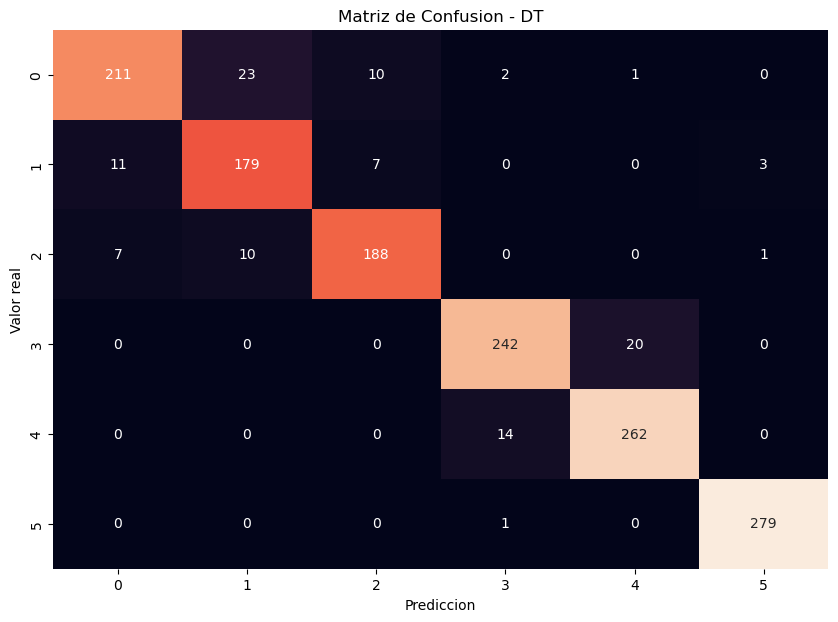

In [62]:
# - PRECISIÓN
accuracy_val_tree = accuracy_score(Y_val, Y_pred_tree)
print(f"Precisión en el conjunto de validación: {accuracy_val_tree * 100:.2f}%")

plt.figure(figsize=(10, 7))
sns.heatmap(confusion_matrix(Y_val, Y_pred_tree), annot=True, fmt='g', cbar=False)
plt.xlabel('Prediccion')
plt.ylabel('Valor real')
plt.title('Matriz de Confusion - DT')
plt.show()

## Training

### Split

### Resultados

## Submission

In [55]:
Y_test_tree = dt.predict(X_test.to_numpy())
print(Y_test_tree.shape)

(2947,)


In [60]:
# Escribiendo a csv
result_csv = pd.DataFrame(Y_test_tree.astype(int))
result_csv.head()
result_csv = result_csv.reset_index()
result_csv['index'] += 1

result_csv.rename(columns={'index': 'ID', 0: 'y'}, inplace=True)

result_csv.to_csv('results.csv', index=False)